In [1]:
%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, t, kstest
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import random
np.random.seed(0)


In [2]:

n = 500
p = 10
iters = 10000
lam = 0.1
true_beta = np.zeros(p)  
std_noise = 10

X = np.random.normal(0, 1, size=(n, p))

In [ ]:


def create_data(X, true_beta, intercept = 0, std_noise = 1):
    n = X.shape[0]
    linear_component = X @ true_beta
    noise = np.random.normal(0, std_noise, size = n)
    y = linear_component + noise + intercept
    return y


def fit_lasso_model_sklearn(X, y, lam):
    model = Lasso(alpha=lam, fit_intercept=True, tol=1e-4, max_iter=2000)
    model.fit(X, y)
    return model.coef_, model.intercept_

def fit_lasso_model(X, y, lam, max_iter = 7000, tol = 1e-5):
    def soft_thresolding(rho, lam, z):
        if rho < -lam:
            return (rho + lam)/z
        elif rho > lam:
            return (rho - lam)/z
        else:
            return 0
    n, p = X.shape
    beta = np.zeros(p)
    residual = y - X @ beta
    intercept = 0
    for iter in range(max_iter):
        beta_old = beta.copy()
        intercept_old = intercept
        for j in range(p):
            r_j = residual + X[:, j] * beta[j]
            rho = 1/n * X[:, j].T @ r_j
            z = 1/n * (X[:, j] ** 2).sum()

            beta[j] = soft_thresolding(rho, lam, z)
            residual = r_j - X[:, j] * beta[j]
        if np.linalg.norm(beta - beta_old, ord=1) < tol and abs(intercept - intercept_old) < tol:
            break
        intercept = np.mean(y) - np.sum(np.mean(X, axis = 0) * beta) 
    return beta, intercept

def calculating_p_value(X, active_set, y, beta_hat, intercept):

    X_active = X[:, active_set]
    beta_hat_active = beta_hat[active_set]
    p_active = len(active_set)
    mat = np.linalg.inv(X_active.T @ X_active)
    sigma_hat_squared = np.sum((y - X_active @ beta_hat_active - intercept) ** 2) / (n - p_active - 1)
    mat *= sigma_hat_squared 
    var = np.diag(mat)
    std = np.sqrt(var)
    t_statistic = (beta_hat_active - 0) / std
    p_values = 2 * (1 - t.cdf(np.abs(t_statistic), df = n - p_active - 1))


    return p_values

In [4]:
beta_hat_list = [] 
p_values_lists = []
ran_p_values_list = []
for iter in range(iters):
    y = create_data(X, true_beta, 0, std_noise)
    beta_hat, intercept = fit_lasso_model(X, y, lam)
    
    full_beta = np.concatenate([[intercept], beta_hat])
    beta_hat_list.append(full_beta)

    active_set = np.where(np.abs(beta_hat) > 1e-8)[0]
    p_values = calculating_p_value(X, active_set, y, beta_hat, intercept)
    p_values_lists.append(p_values)

    if len(p_values) > 0:   
        ran_p_value = random.choice(p_values)
        ran_p_values_list.append(ran_p_value)

102.1718209164792
92.14410828669477
107.89425215976173
96.34842574207569
96.22958982583607
95.37115133050064
93.08874581749251
92.4445868625909
102.76933501399711
100.05861170702353
93.89770411513966
105.95180817802068
94.76567872549552
106.99000951907097
106.60377382344403
102.07500733314913
89.78827975494127
99.92959396136582
93.49311485089252
87.74422099559523
103.76933127260287
94.61870244106593
90.95829292598509
99.23527974508073
105.64167256145367
97.66800052452238
90.83894105126919
97.90817726059738
101.17504988653592
101.77693862756556
96.14923221122505
100.69289764063207
99.34769574445853
89.71035208371947
109.80438553741165
102.55729014167659
100.20748075548163
96.24976196210724
93.19202148665997
97.20338599064114
99.01337736712493
100.2009157042238
96.38258679007922
103.77993174750824
103.45867645194946
96.45849526355731
101.29445001333734
101.38875567008952
93.50745491080788
104.46459191615487
107.8133061161854
113.60589667880393
95.15246835948622
99.77691289028276
93.99563

Text(0.5, 1.0, 'intercept')

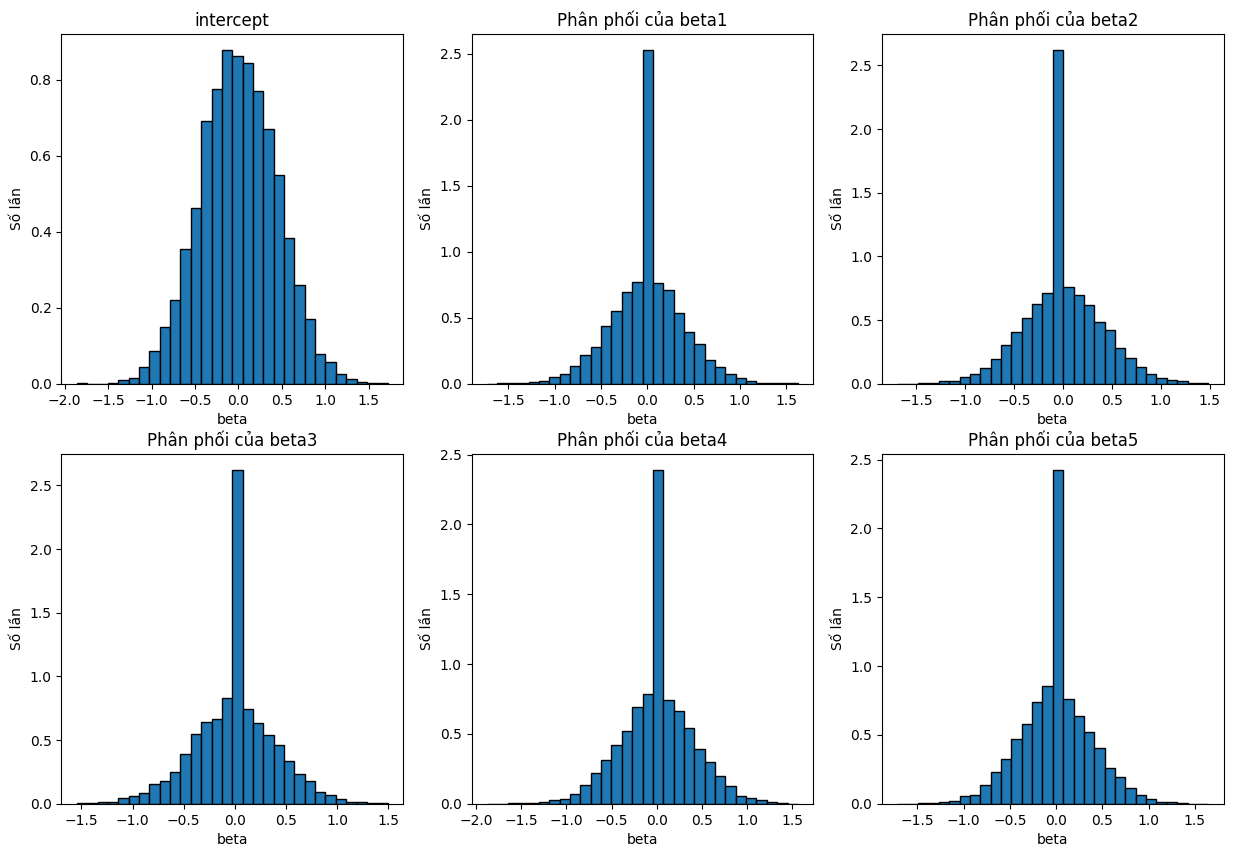

In [5]:
beta_df = pd.DataFrame(beta_hat_list)

fig, axes = plt.subplots(2, 3, figsize = (15, 10))
axes = axes.flatten()

for idx in range(6):
    axes[idx].hist(beta_df[idx], bins = 30, density = True,edgecolor = 'black')
    axes[idx].set_title(f'Phân phối của beta{idx}')
    axes[idx].set_xlabel('beta')
    axes[idx].set_ylabel('Số lần')
axes[0].set_title(f'intercept')

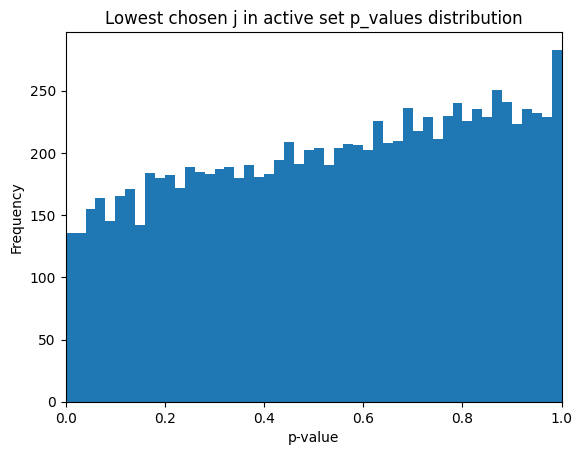

In [6]:


plt.figure()
plt.xlim(0, 1)
plt.hist(ran_p_values_list, bins = 50)
plt.title(f'Lowest chosen j in active set p_values distribution')
plt.xlabel(f'p-value')
plt.ylabel(f'Frequency')

plt.show()


In [7]:
ran_p_values_list = np.array(ran_p_values_list)
print(np.max(ran_p_values_list))
print(len(ran_p_values_list))
print(np.sum(ran_p_values_list > 0.8))
print(np.sum(ran_p_values_list<0.2))

0.9999274229408421
10000
2384
1578
